# Probabilistic PCA (PPCA) Demo

This notebook demonstrates the usage and features of the Probabilistic PCA (PPCA) implementation, including a comparison to scikit-learn's PCA, handling of missing data, posterior inference, imputation, and application to large datasets.



## Table of Contents

1. [Quick Comparison: PPCA vs. sklearn PCA](#comparison)
2. [Handling Missing Data through Probabilistic Inference](#missing-data)
3. [Imputation of Missing Values](#imputation)
4. [Large-Scale Example and Online Learning](#mnist)
5. [Conclusion](#conclusion)


In [1]:
# Install necessary packages
%pip install matplotlib scikit-learn

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8c/af/30ddefe19ca67eebd70047dabf50f899eaff6f3c5e6a1a7edaecaf63f794/matplotlib-3.10.6-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.10.6-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8c/af/30ddefe19ca67eebd70047dabf50f899eaff6f3c5e6a1a7edaecaf63f794/matplotlib-3.10.6-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.10.6-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/18/d6/ba863a4171ac9d7314c4d3fc251f015704a2caeee41ced89f321c049ed83/scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/18/d6/ba863a4171ac9d7314c4d3fc251f015704a2caeee41ced89f321c049e

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl
import numpy as np

from scipy.stats import gaussian_kde
from scipy.linalg import subspace_angles

from sklearn.decomposition import PCA as PCA_sklearn
from sklearn.datasets import load_iris, fetch_openml

from lib_ppca import PPCA

np.random.seed(1)

<a id="comparison"></a>

## 1. Quick Comparison: PPCA vs. sklearn PCA

We begin by comparing the results of the standard PCA implementation from scikit-learn with the PPCA implementation. This section demonstrates that PPCA recovers the same principal subspace as classical PCA when there is no missing data. 

As a first qualitative comparison we can plot the transformed values of both the sklearn PCA and our implementation of PPCA, and observe that they are almost identical.

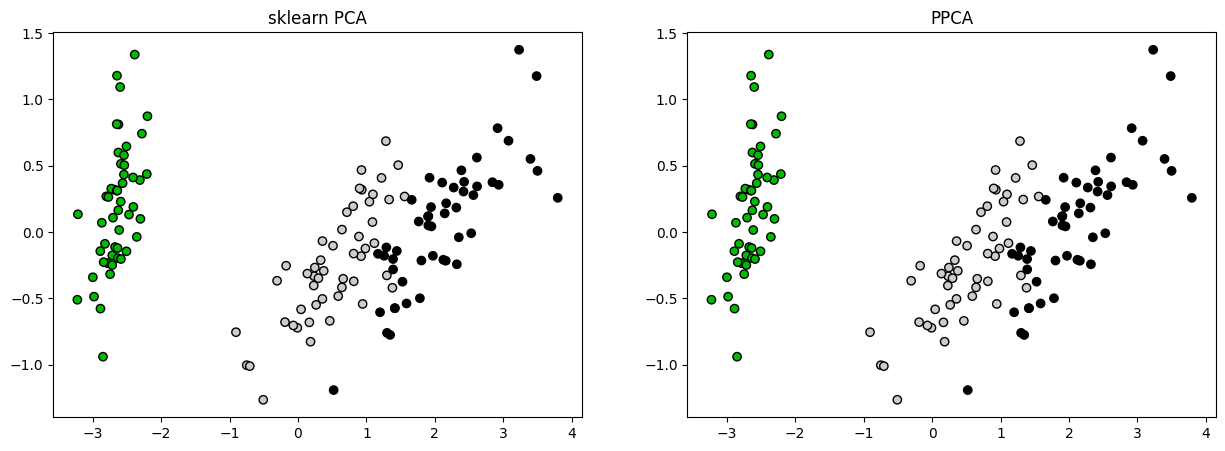

In [3]:
# Helper functions to mimic classical PCA
def transform(X, mean, components):
    return (X - mean[None, :]) @ components.T

def inverse_transform(X, mean, components):
    return (X @ components) + mean[None, :]

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target
y = np.choose(y, [1, 2, 0]).astype(float)

# Apply PCA
pca_sklearn = PCA_sklearn(n_components=2)
Z_sklearn = pca_sklearn.fit_transform(X)

ppca = PPCA(n_components=2, rtol=1e-16)
ppca.fit(X)
Z = transform(X, ppca.mean_, ppca.components_)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
Zs = [Z_sklearn, Z]
titles = ["sklearn PCA", "PPCA"]
for i, (data, title) in enumerate(zip(Zs, titles)):
    ax[i].scatter(data[:, 0], data[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
    ax[i].set_title(title)
plt.show()

**Result:**

Both PPCA and sklearn PCA produce nearly identical projections when the data is complete, confirming that PPCA generalizes classical PCA.

To quantify the dissimilarity of the principle component subspaces learned by the two implementations, we can compute their angle. Indeed the angle is tiny, meaning that the learned principle subspaces are identical:

In [4]:
print("Angle between subspaces: {}".format(np.rad2deg(subspace_angles(pca_sklearn.components_.T, ppca.components_.T)[0])))

Angle between subspaces: 9.81142845608868e-13


Finally, we can look at some of the attributes and compare them. Note that scikit-learn applies a Bessel correction to its estimates (their variance estimation uses (n_samples - 1) degrees of freedom). In contrast, the PPCA implementation maintains maximum likelihood estimates, as using a Bessel correction would introduce a conceptual mismatch with respect to the probabilistic model.

To compare PPCA estimates with scikit-learn, we can therefore adjust the parameters of the PPCA model manually after fitting:

In [5]:
params = ppca.get_params()
params["W"] *= np.sqrt(ppca.n_samples_ / (ppca.n_samples_ - 1))
params["sig2"] *= ppca.n_samples_ / (ppca.n_samples_ - 1)
ppca.set_params(params)

In [6]:
print("{0: >30} {1: >40} {2: >40}".format("Attribute", "sklearn PCA", "PPCA"))
strfmt = "{0: >30} {1: >40} {2: >40}"
print(strfmt.format("explained_variance_", np.array2string(pca_sklearn.explained_variance_), np.array2string(ppca.explained_variance_)))
print(strfmt.format("explained_variance_ratio_", np.array2string(pca_sklearn.explained_variance_ratio_), np.array2string(ppca.explained_variance_ratio_)))
print(strfmt.format("noise_variance_", np.array2string(pca_sklearn.noise_variance_), np.array2string(ppca.noise_variance_)))
# We can also construct singular values from PPCA (even though we don't solve via SVD)
print(strfmt.format("singular_values_", np.array2string(pca_sklearn.singular_values_), np.array2string(np.sqrt(ppca.explained_variance_ * (ppca.n_samples_ - 1)))))

                     Attribute                              sklearn PCA                                     PPCA
           explained_variance_                  [4.22824171 0.24267075]                  [4.22823912 0.24267075]
     explained_variance_ratio_                  [0.92461872 0.05306648]                  [0.92461868 0.05306651]
               noise_variance_                                0.0510223                                0.0510223
              singular_values_                [25.09996044  6.01314738]                [25.09995277  6.01314738]


Comparing the principle axes:

In [7]:
print("sklearn PCA components:")
print(pca_sklearn.components_)

print("PPCA components:")
print(ppca.components_)

sklearn PCA components:
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
PPCA components:
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


We can also compare the log-likelihood, covariance, and precision. PPCA uses exactly the same interface as scikit-learn.

In [8]:
print("sklearn mean log-likelihood:")
print(pca_sklearn.score(X))

print("PPCA mean log-likelihood:")
print(ppca.score(X))

print("sklearn log-likelihood:")
print(pca_sklearn.score_samples(X[:3]))

print("PPCA log-likelihood:")
print(ppca.score_samples(X[:3]))

print("sklearn covariance")
print(pca_sklearn.get_covariance())

print("PPCA covariance")
print(ppca.get_covariance())

print("sklearn precision")
print(pca_sklearn.get_precision())

print("PPCA precision")
print(ppca.get_precision())

sklearn mean log-likelihood:
-2.6997965106756645
PPCA mean log-likelihood:
-2.699796508663593
sklearn log-likelihood:
[-1.7829611  -2.1789704  -1.75043369]
PPCA log-likelihood:
[-1.78296132 -2.17897063 -1.75043399]
sklearn covariance
[[ 0.67918961 -0.03571514  1.2714061   0.53137208]
 [-0.03571514  0.18303922 -0.32672469 -0.13706322]
 [ 1.2714061  -0.32672469  3.12237957  1.28464626]
 [ 0.53137208 -0.13706322  1.28464626  0.58834865]]
PPCA covariance
[[ 0.67918927 -0.03571506  1.2714053   0.53137175]
 [-0.03571506  0.1830392  -0.3267245  -0.13706315]
 [ 1.2714053  -0.3267245   3.12237767  1.28464546]
 [ 0.53137175 -0.13706315  1.28464546  0.58834831]]
sklearn precision
[[10.39758907 -6.82917889 -4.23252176 -1.73999651]
 [-6.82917889 11.20882342  3.36143788  1.43944224]
 [-4.23252176  3.36143788  4.9239846  -6.14568419]
 [-1.73999651  1.43944224 -6.14568419 17.02546685]]
PPCA precision
[[10.39758906 -6.82917886 -4.2325217  -1.73999649]
 [-6.82917886 11.20882339  3.36143785  1.43944223]


<a id="missing-data"></a>

## 2. Handling Missing Data through Probabilistic Inference

PPCA provides a probabilistic model of the data, allowing us to compute the posterior distribution over latent variables. Unlike classical PCA, it can thus naturally handle missing values in the data. In this section, we demonstrate how PPCA can fit a model and infer latent variables even when some data is missing.

For PPCA, we plot the posterior mean of the latent variables, and draw ellipses to mark one standard deviation of the covariance.

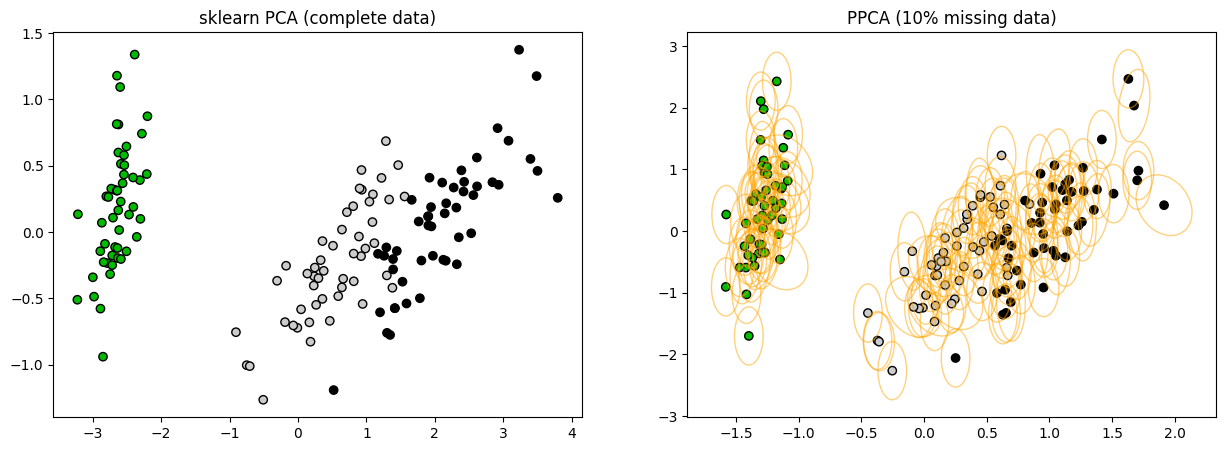

In [9]:
def draw_ellipse(ax, cov, mean):
    pearson = cov[:, 0, 1]/np.sqrt(cov[:, 0, 0] * cov[:, 1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    for i in range(len(cov)):
        ellipse = Ellipse((0,0), width=ell_radius_x[i] * 2, height=ell_radius_y[i] * 2, facecolor='none', edgecolor='orange', alpha=0.5)
        scale_x = np.sqrt(cov[i, 0, 0]) * 1
        scale_y = np.sqrt(cov[i, 1, 1]) * 1
        mean_x = mean[i, 0]
        mean_y = mean[i, 1]
        transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)

def generate_missing_data(X, p, random_state=None):
    n_samples, n_features = X.shape
    max_p = 1 / n_features
    if p > max_p:
        raise ValueError(f"p={p} too large; max is {max_p:.3f} for {n_features} features.")
    rng = np.random.default_rng(random_state)
    n_missing = int(round(p * n_samples * n_features))
    rows = rng.choice(n_samples, size=n_missing, replace=False)
    cols = rng.integers(0, n_features, size=n_missing)
    missing = np.zeros_like(X, dtype=bool)
    missing[rows, cols] = True
    X_missing = X.copy()
    X_missing[missing] = np.nan
    return X_missing, missing

# Set 10% of the data missing
X_missing, missing = generate_missing_data(X, p=0.1, random_state=0)

ppca = PPCA(n_components=2)
ppca.fit(X_missing)
mZ, covZ = ppca.posterior_latent(X_missing)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(Z_sklearn[:, 0], Z_sklearn[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
ax[0].set_title("sklearn PCA (complete data)")
ax[1].scatter(mZ[:, 0], mZ[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
draw_ellipse(ax[1], covZ, mZ)
ax[1].set_title("PPCA (10% missing data)")
plt.show()

**Result:**

PPCA is able to recover meaningful latent representations even when 10% of the data is missing, while sklearn PCA cannot be applied to incomplete data.

Instead of returning the latent posterior distribution parameters, we can also sample latent variables from it. Here we sample 100 data sets, and compute the resulting latent density.

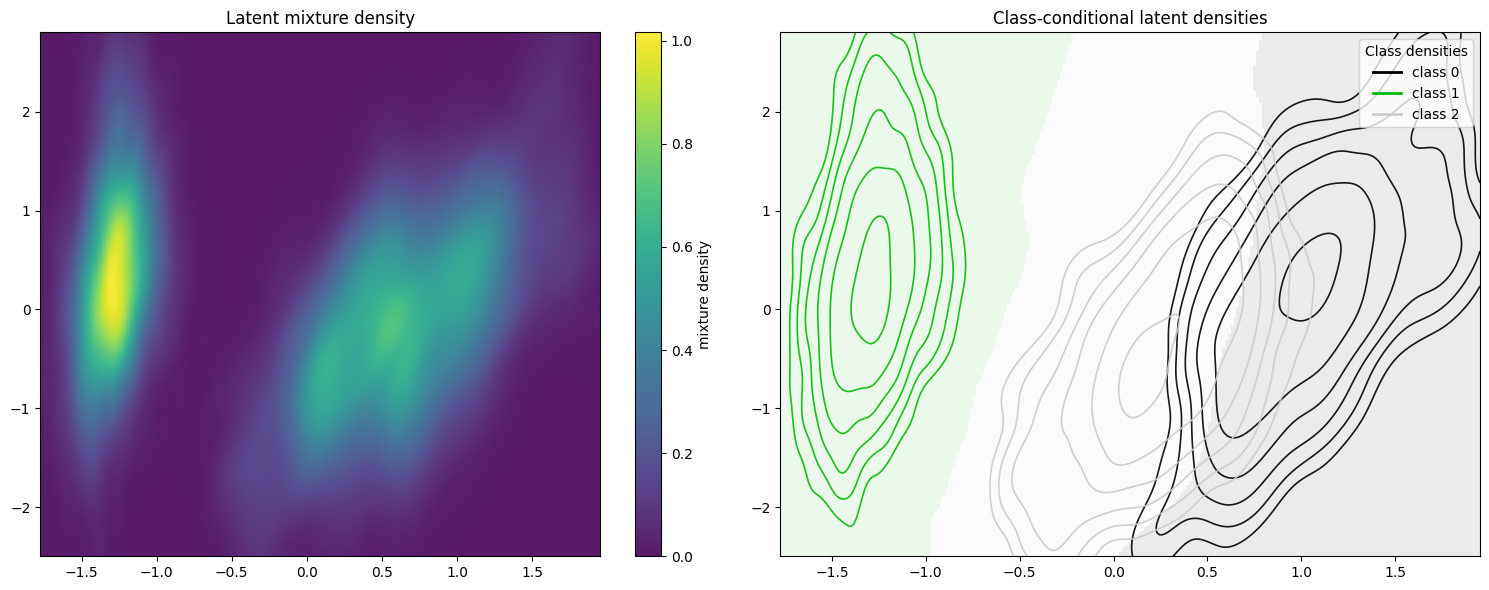

In [10]:
# Function to plot latent densities
def plot_latent_densities(Z_sample, y):
    # Collect per-class samples
    class_kdes = {}
    class_sample_counts = {}
    all_points = []

    classes = np.unique(y)
    for c in classes:
        idx = np.where(y == c)[0]
        if len(idx) == 0:
            continue
        pts = Z_sample[:, idx, :].reshape(-1, 2)  # (n_draws * n_class_obs, 2)
        # Need at least 2 points for KDE
        if pts.shape[0] > 5:
            class_kdes[c] = gaussian_kde(pts.T)
            class_sample_counts[c] = pts.shape[0]
            all_points.append(pts)

    # Fallback if no KDEs
    if not class_kdes:
        raise RuntimeError("No class had enough samples for KDE.")

    # Grid bounds from all class samples (robust percentiles)
    stack_all = np.vstack(all_points)
    xmin, xmax = np.percentile(stack_all[:,0], [1, 99])
    ymin, ymax = np.percentile(stack_all[:,1], [1, 99])
    padx = 0.05 * (xmax - xmin)
    pady = 0.05 * (ymax - ymin)
    xmin -= padx; xmax += padx
    ymin -= pady; ymax += pady

    gx, gy = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
    grid = np.vstack([gx.ravel(), gy.ravel()])

    # Evaluate each class density
    densities = {}
    for c, kde in class_kdes.items():
        densities[c] = kde(grid).reshape(gx.shape)

    # Mixture (unnormalized) density for reference (sum of class densities)
    mixture = np.zeros_like(gx)
    for c in densities:
        mixture += densities[c]

    # Argmax class map (for optional background classification)
    argmax_map = np.full(gx.shape, np.nan)
    if len(densities) > 1:
        # stack into array (n_classes, H, W)
        cls_list = list(densities.keys())
        stack = np.stack([densities[c] for c in cls_list], axis=0)
        winner = np.argmax(stack, axis=0)
        argmax_map = np.vectorize(lambda i: cls_list[i])(winner)

    fig, ax = plt.subplots(1, 2, figsize=(15,6))

    cmap = plt.cm.nipy_spectral
    norm = mpl.colors.Normalize(vmin=classes.min(), vmax=classes.max())

    # Left: mixture density + posterior mean scatter colored by class
    im = ax[0].imshow(
        np.rot90(mixture),
        cmap="viridis",
        extent=[xmin, xmax, ymin, ymax],
        aspect="auto",
        alpha=0.9
    )
    ax[0].set_title("Latent mixture density")
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.set_label("mixture density")

    # Right: per-class contours + original plot (means, ellipses)
    # Optional: faint classification background
    if len(densities) > 1:
        # Map classes to RGBA with low alpha
        class_color_img = np.zeros(argmax_map.shape + (4,))
        for c in classes:
            mask = argmax_map == c
            if np.any(mask):
                rgba = cmap(norm(c))
                class_color_img[mask] = (rgba[0], rgba[1], rgba[2], 0.08)
        ax[1].imshow(
            np.rot90(class_color_img),
            extent=[xmin, xmax, ymin, ymax],
            aspect="auto",
            interpolation="nearest"
        )

    # Class contour overlays
    for c in classes:
        if c not in densities:
            continue
        color = cmap(norm(c))
        # Choose contour levels relative per class
        d = densities[c]
        vmax = np.percentile(d, 99)
        vmin = vmax * 0.05
        levels = np.geomspace(vmin, vmax, 6)
        ax[1].contour(gx, gy, d, levels=levels, colors=[color], linewidths=1.2, alpha=0.9)

    # Legend handles
    handles = [mpl.lines.Line2D([0],[0], color=cmap(norm(c)), lw=2, label=f"class {int(c)}") for c in classes if c in densities]
    ax[1].legend(handles=handles, title="Class densities", loc="upper right", frameon=True)
    ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
    ax[1].set_title("Class-conditional latent densities")

    plt.tight_layout()
    plt.show()


Z_sample = ppca.sample_posterior_latent(X_missing, n_draws=100)
plot_latent_densities(Z_sample, y)

To get a better idea of PPCA's robustness to missing values, we can plot the angle of the resulting subspaces to the complete sklearn PCA as a function of the missingness percentage.

Note also that PPCA is reasonable fast considering it is an iterative method. On a MacBook M3 100 fits on the Iris dataset take around 1.7 seconds.

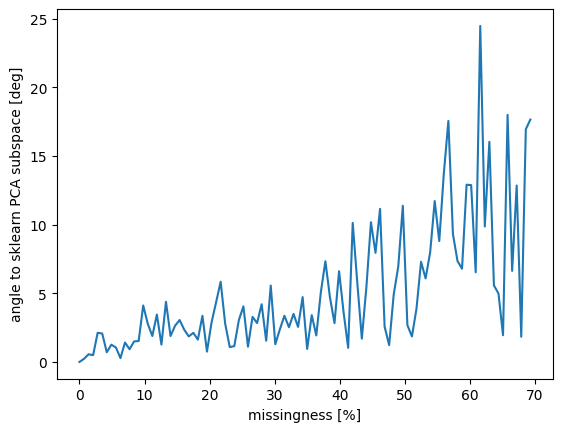

CPU times: user 1.85 s, sys: 13.6 ms, total: 1.87 s
Wall time: 1.97 s


In [11]:
%%time
missingness = np.linspace(0, 0.7, 100, endpoint=False)

angles = []
for m in missingness:
    # Remove m% of the data randomly
    missing = np.random.uniform(size=X.shape) < m
    X_missing = X.copy()
    X_missing[missing] = np.nan
    # Remove observations which have all nans...
    all_missing = np.all(np.isnan(X_missing), axis=1)
    X_missing = X_missing[~all_missing, :]

    ppca = PPCA(n_components=2)
    ppca.fit(X_missing)
    angles.append(np.rad2deg(subspace_angles(pca_sklearn.components_.T, ppca.components_.T)[0]))

plt.figure()
plt.plot(missingness * 100, angles)
plt.xlabel("missingness [%]")
plt.ylabel("angle to sklearn PCA subspace [deg]")
plt.show()

A straightforward choice for encoding values with PPCA would be the posterior means. From the latent code, we can then also use the PPCA model to reconstruct some data via the likelihood and compare it to the original dataset.

In [12]:
# Remove 10% of the data randomly
missing = np.random.uniform(size=X.shape) < 0.1
X_missing = X.copy()
X_missing[missing] = np.nan

ppca = PPCA(n_components=2)
ppca.fit(X_missing)

Z = ppca.posterior_latent(X_missing)[0]

mX, covX = ppca.likelihood(Z)
print(f"residual root mean square error: {np.sqrt(np.nanmean((X_missing - mX) ** 2)):.6f}")

residual root mean square error: 0.164356


PPCA reconstructions are not ideal in the squared residual error sense, because the projection is not orthogonal due to the learned noise. We can use an orthogonal reconstruction for the noisy model, which will have a lower RMSE.

In [13]:
X_hat = ppca.lmmse_reconstruction(Z)
print(f"residual root mean square error: {np.sqrt(np.nanmean((X_missing - X_hat) ** 2)):.6f}")

residual root mean square error: 0.154304


<a id="imputation"></a>

## 3. Imputation of Missing Values

PPCA can be used to impute missing values in the data by leveraging the conditional posterior predictive distribution. This section demonstrates both mean imputation and multiple imputation using samples from the posterior.

In [14]:
# Impute missing values by computing p(X | X_obs)
# X_imputed_mean could be used downstream
X_imputed_mean, X_imputed_cov = ppca.impute_missing(X_missing)

# Sample 10 datasets --> multiple imputation
X_samples = ppca.sample_missing(X_missing, n_draws=10)  # shape: (n_draws, n_samples, n_features)

In [15]:
# Observed values are fixed, missing values vary
print(X_samples[0, :10])  # first draw

print(X_samples[1, :10])  # second draw

[[5.1        3.5        1.4        0.2       ]
 [4.9        3.4246682  1.4        0.2       ]
 [4.7        3.2        1.3        0.2       ]
 [4.6        3.1        1.5        0.2       ]
 [5.         3.6        1.4        0.2       ]
 [5.4        3.9        1.7        0.4       ]
 [4.6        3.4        1.4        0.3       ]
 [5.         3.4        1.5        0.27474534]
 [4.4        2.9        1.4        0.2       ]
 [4.9        3.1        1.5        0.1       ]]
[[5.1        3.5        1.4        0.2       ]
 [4.9        3.60021299 1.4        0.2       ]
 [4.7        3.2        1.3        0.2       ]
 [4.6        3.1        1.5        0.2       ]
 [5.         3.6        1.4        0.2       ]
 [5.4        3.9        1.7        0.4       ]
 [4.6        3.4        1.4        0.3       ]
 [5.         3.4        1.5        0.45729462]
 [4.4        2.9        1.4        0.2       ]
 [4.9        3.1        1.5        0.1       ]]


**Result:**

PPCA enables principled imputation of missing values, providing both mean estimates and samples for multiple imputation, which is useful for uncertainty quantification.

<a id="mnist"></a>

## 4. Large-Scale Example and Online Learning

To demonstrate the scalability of PPCA, we apply it to the MNIST dataset (70,000 samples, 784 features).

PPCA can also be fit in an on-line form, where the model is trained on mini-batches of data. This enables fitting for datasets with a very large number of samples. In the following we compare the memory usage and results for batch and online PPCA.

In [16]:
del pca_sklearn
del ppca

mnist = fetch_openml('mnist_784', as_frame=False, parser='liac-arff')
X = mnist.data
y = mnist.target
X.shape

(70000, 784)

In [17]:
%pip install memory_profiler
%load_ext memory_profiler

  Obtaining dependency information for memory_profiler from https://files.pythonhosted.org/packages/49/26/aaca612a0634ceede20682e692a6c55e35a94c21ba36b807cc40fe910ae1/memory_profiler-0.61.0-py3-none-any.whl.metadata
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
%memit
# Fit on a single batch
ppca = PPCA(n_components=5)
ppca.fit(X)

peak memory: 627.81 MiB, increment: 0.02 MiB


In [19]:
params = ppca.get_params()
del ppca

In [20]:
%memit
# Fit on mini-batches of 1000 samples
online_ppca = PPCA(n_components=5, batch_size=1000)
online_ppca.fit(X)

peak memory: 315.45 MiB, increment: 0.19 MiB


In [21]:
online_params = online_ppca.get_params()
del online_ppca

In [22]:
# Compare parameters of full vs online model
print(f"Noise covariance full model: {params['sig2']}")

print(f"Noise covariance online model: {online_params['sig2']}")

Noise covariance full model: 2934.9793689782623
Noise covariance online model: 2934.9807363078817


Finally, we can visualize the first two principle components of the MNIST dataset.

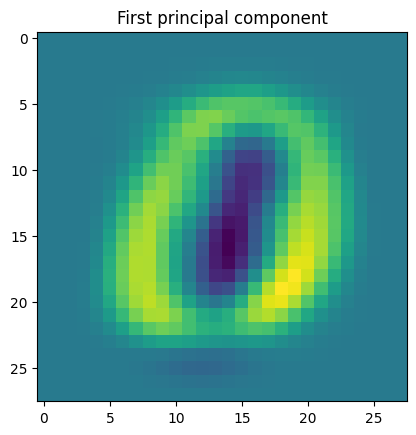

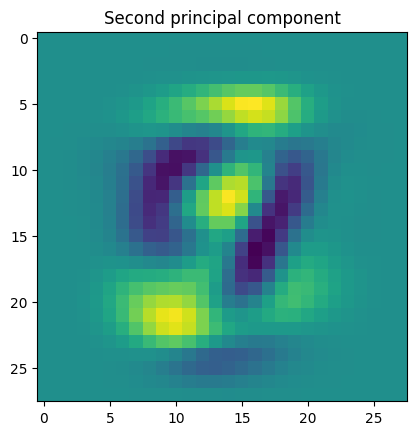

In [23]:
plt.imshow(online_params["W"][0].reshape(28, 28), aspect='equal', cmap='viridis')
plt.title("First principal component")
plt.show()
plt.imshow(online_params["W"][1].reshape(28, 28), aspect='equal', cmap='viridis')
plt.title("Second principal component")
plt.show()

<a id="conclusion"></a>

## 5. Conclusion

This notebook demonstrated the flexibility and power of Probabilistic PCA (PPCA):
- PPCA recovers the same principal subspace as classical PCA when data is complete.
- PPCA can handle missing data natively, unlike classical PCA.
- The probabilistic nature of PPCA enables posterior inference, uncertainty quantification, and principled imputation.
- PPCA scales to large datasets and supports online learning.

For more details, see the [README](../README.md) or the source code.